In [2]:
pip install transformers pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.2 MB/s eta 0:00:00


In [39]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
from pyvis.network import Network
import IPython
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
# autotokenizer va automodelforseq2 az RABEL bayad load shavand:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
print("Autotokenizer and AutoModelForSeq2 are ready to use!")

Autotokenizer and AutoModelForSeq2 are ready to use!


In [15]:
class KnowledgeBase():
    #in celas KnowledgeBase ra dar khod zakhire mikonad.
    def __init__(self):
        self.entries = []

    def are_entries_equal(self, e1, e2):
        return all(e1[attr] == e2[attr] for attr in ["head", "type", "tail"])

    def does_entry_exist(self, entry):
        return any(self.are_entries_equal(entry, e) for e in self.entries)

    def add_entry(self, entry):
        if not self.does_entry_exist(entry):
            self.entries.append(entry)

    def __str__(self):
        return '\n'.join(str(entry) for entry in self.entries)

    def get_entries(self):
        return self.entries


In [19]:
def process_model_output(text):
    print(f"process_model_output running for [{text}].")
    rels = []
    rel_type, subject, rel_type, obj = '', '', '', ''
    text = text.strip()
    current = 'x'
    replaced_text = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in replaced_text.split():
        if token == "<triplet>":
            current = 't'
            if rel_type != '':
                rels.append({
                    'head': subject.strip(),
                    'type': rel_type.strip(),
                    'tail': obj.strip()
                })
                rel_type = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if rel_type != '':
                rels.append({
                    'head': subject.strip(),
                    'type': rel_type.strip(),
                    'tail': obj.strip()
                })
            obj = ''
        elif token == "<obj>":
            current = 'o'
            rel_type = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                obj += ' ' + token
            elif current == 'o':
                rel_type += ' ' + token
    if subject != '' and rel_type != '' and obj != '':
        rels.append({
            'head': subject.strip(),
            'type': rel_type.strip(),
            'tail': obj.strip()
        })
    return rels


In [30]:
def convert_text_to_kb(input_text, verbose=False):
    print("********************************************************************************")
    print("Text to Knowledgebase Running. This outputs are for goly (golkar) debugs:")
    cache_knowledge_base = KnowledgeBase()

    # Tokenize the input text
    encoded_inputs = tokenizer(input_text, max_length=512, padding=True, truncation=True,
                               return_tensors='pt')
    if verbose:
        print(f"tokens in encoded inputs: {len(encoded_inputs['input_ids'][0])}")

    # Generate predictions
    generation_parameters = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": 3
    }
    generated_tokens = model.generate(
        **encoded_inputs,
        **generation_parameters,
    )
    decoded_predictions = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    # Create the knowledge base
    for sentence_prediction in decoded_predictions:
        extracted_relations = process_model_output(sentence_prediction)
        for relation in extracted_relations:
            cache_knowledge_base.add_entry(relation)
    print("********************************************************************************")
    return cache_knowledge_base

In [33]:
text = "John works in Google, while Mahdi works in Yahoo."
my_kb = convert_text_to_kb(text, verbose=True)
print(my_kb)

********************************************************************************
Text to Knowledgebase Running. This outputs are for goly (golkar) debugs:
tokens in encoded inputs: 14
process_model_output running for [<s><triplet> Google <subj> Yahoo <obj> subsidiary</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>].
process_model_output running for [<s><triplet> Google <subj> Yahoo <obj> subsidiary <triplet> Yahoo <subj> Google <obj> parent organization</s>].
process_model_output running for [<s><triplet> John <subj> Google <obj> employer <triplet> Mahdi <subj> Yahoo <obj> employer</s>].
********************************************************************************
{'head': 'Google', 'type': 'subsidiary', 'tail': 'Yahoo'}
{'head': 'Yahoo', 'type': 'parent organization', 'tail': 'Google'}
{'head': 'John', 'type': 'employer', 'tail': 'Google'}
{'head': 'Mahdi', 'type': 'employer', 'tail': 'Yahoo'}


In [35]:
print(type(my_kb))
data_list = my_kb.get_entries()
print(type(data_list))
for i in data_list:
  print(i)

<class '__main__.KnowledgeBase'>
<class 'list'>
{'head': 'Google', 'type': 'subsidiary', 'tail': 'Yahoo'}
{'head': 'Yahoo', 'type': 'parent organization', 'tail': 'Google'}
{'head': 'John', 'type': 'employer', 'tail': 'Google'}
{'head': 'Mahdi', 'type': 'employer', 'tail': 'Yahoo'}


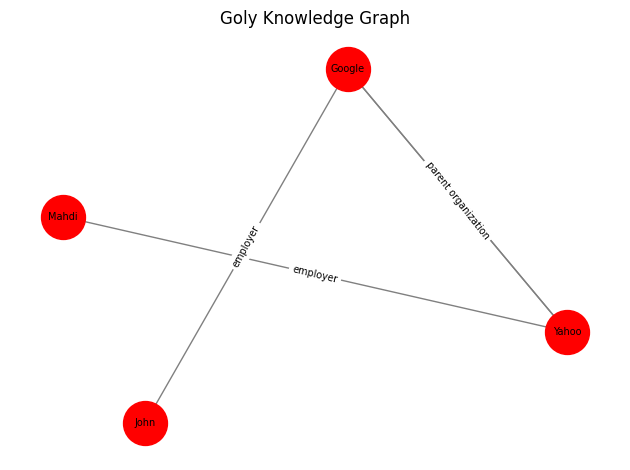

In [36]:
#SHOWTIME:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
for entry in data_list:
    head = entry['head']
    tail = entry['tail']
    edge_type = entry['type']
    
    graph.add_edge(head, tail, type=edge_type)

pos = nx.spring_layout(graph, seed=42, k=1.5)  

node_color = 'red'
edge_color = 'gray'
edge_width = 1.0
font_size = 7
font_color = 'black'

# nodes
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=node_color)
# edges
nx.draw_networkx_edges(graph, pos, arrows=True, edge_color=edge_color, width=edge_width)
# node labels
nx.draw_networkx_labels(graph, pos, font_size=font_size, font_color=font_color)
# edge labels
edge_labels = nx.get_edge_attributes(graph, 'type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=font_size, font_color=font_color)
plt.axis('off')
plt.title('Goly Knowledge Graph')
plt.tight_layout()

plt.show()

********************************************************************************
Text to Knowledgebase Running. This outputs are for goly (golkar) debugs:
tokens in encoded inputs: 112
process_model_output running for [<s><triplet> Iran <subj> Iraq <obj> shares border with <subj> Turkey <obj> shares border with <subj> Armenia <obj> shares border with <subj> Azerbaijan <obj> shares border with <subj> Turkmenistan <obj> shares border with <subj> Afghanistan <obj> shares border with <subj> Pakistan <obj> shares border with <triplet> Iran <subj> Iraq <obj> shares border with <subj> Turkey <obj> shares border with <subj> Armenia <obj> shares border with <subj> Azerbaijan <obj> shares border with <subj> Turkmenistan <obj> shares border with <subj> Afghanistan <obj> shares border with <subj> Pakistan <obj> shares border with <triplet> Iraq <subj></s>].
process_model_output running for [<s><triplet> Iraq <subj> Iran <obj> shares border with <subj> Iran <obj> shares border with <subj> Iran <obj

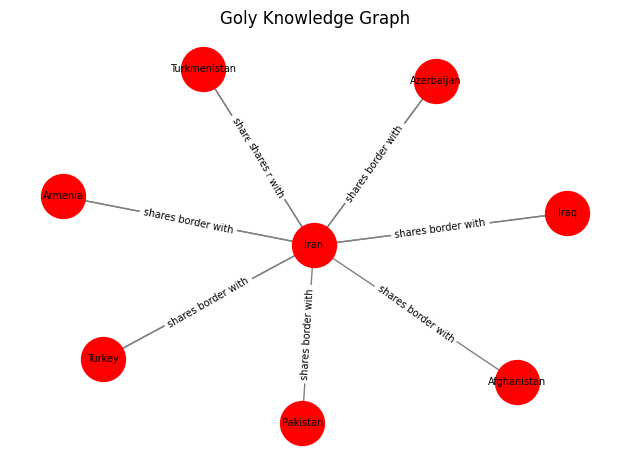

In [37]:
#Bigger text example:
text = "Iran, officially known as the Islamic Republic of Iran, is a country located in the Middle East in southwestern Asia. It is bordered by Iraq, Turkey, Armenia, Azerbaijan, Turkmenistan, Afghanistan, and Pakistan. Iran has a rich history and is home to one of the world's oldest continuous major civilizations. Tehran is the capital and largest city of Iran. The country is known for its diverse landscapes, including deserts, mountains, and coastal areas. Iran is also famous for its cultural heritage, including its art, literature, and architecture."
my_kb = convert_text_to_kb(text, verbose=True)
data_list = my_kb.get_entries()
#SHOWTIME:
import networkx as nx
import matplotlib.pyplot as plt
graph = nx.DiGraph()
for entry in data_list:
    head = entry['head']
    tail = entry['tail']
    edge_type = entry['type']
    
    graph.add_edge(head, tail, type=edge_type)

pos = nx.spring_layout(graph, seed=42, k=1.5)  

node_color = 'red'
edge_color = 'gray'
edge_width = 1.0
font_size = 7
font_color = 'black'
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=node_color)
nx.draw_networkx_edges(graph, pos, arrows=True, edge_color=edge_color, width=edge_width)
nx.draw_networkx_labels(graph, pos, font_size=font_size, font_color=font_color)
edge_labels = nx.get_edge_attributes(graph, 'type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=font_size, font_color=font_color)
plt.axis('off')
plt.title('Goly Knowledge Graph')
plt.tight_layout()

plt.show()

********************************************************************************
Text to Knowledgebase Running. This outputs are for goly (golkar) debugs:
tokens in encoded inputs: 126
process_model_output running for [<s><triplet> Vladimir Putin <subj> President of Russia <obj> position held <triplet> President of Russia <subj> Vladimir Putin <obj> officeholder</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>].
process_model_output running for [<s><triplet> Vladimir Putin <subj> President of Russia <obj> position held <subj> Saint Petersburg <obj> place of birth <subj> Russia <obj> country of citizenship <triplet> President of Russia <subj> Vladimir Putin <obj> officeholder <subj> Russia <obj> country <triplet> Saint Petersb

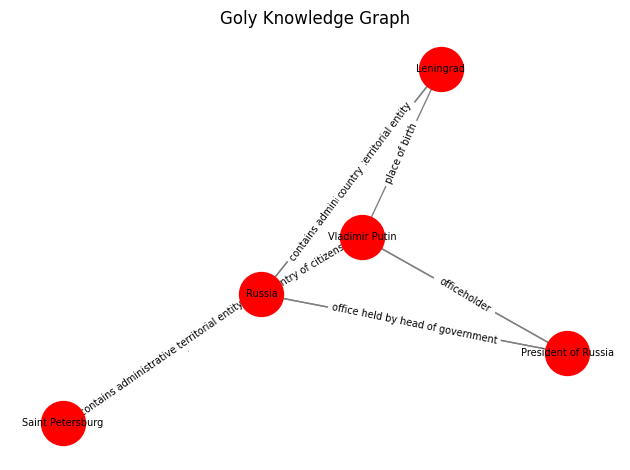

In [38]:
#a little more Bigger text example:
text = "Vladimir Putin is a Russian politician who has served as the President of Russia since 1999, with a brief break as Prime Minister from 2008 to 2012. He is known for his strong leadership and influence in Russian politics. Putin was born on October 7, 1952, in Leningrad (now Saint Petersburg), Russia. He is married to Lyudmila Shkrebneva (formerly Putin) from 1983 to 2014, and they have two daughters named Maria and Katerina. Putin prefers to keep his personal life private, and not much information is publicly available about his family's activities or involvement in politics."
my_kb = convert_text_to_kb(text, verbose=True)
data_list = my_kb.get_entries()
#SHOWTIME:
import networkx as nx
import matplotlib.pyplot as plt
graph = nx.DiGraph()
for entry in data_list:
    head = entry['head']
    tail = entry['tail']
    edge_type = entry['type']
    
    graph.add_edge(head, tail, type=edge_type)

pos = nx.spring_layout(graph, seed=42, k=1.5)  

node_color = 'red'
edge_color = 'gray'
edge_width = 1.0
font_size = 7
font_color = 'black'
nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=node_color)
nx.draw_networkx_edges(graph, pos, arrows=True, edge_color=edge_color, width=edge_width)
nx.draw_networkx_labels(graph, pos, font_size=font_size, font_color=font_color)
edge_labels = nx.get_edge_attributes(graph, 'type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=font_size, font_color=font_color)
plt.axis('off')
plt.title('Goly Knowledge Graph')
plt.tight_layout()

plt.show()